In [1]:
import sys
sys.path.append('../scripts')  # Path relative to the notebook

import numpy as np
import matplotlib.pyplot as plt
import buoypy as bp
from scipy import stats, signal
import cem_utils as utils  # Now you can import it

In [2]:
Hs,Tp,Dir,A,U = utils.compute_wave_parameters(46229, (2005,2024), 71)

Appending data from: http://www.ndbc.noaa.gov/view_text_file.php?filename=46229h2005.txt.gz&dir=data/historical/stdmet/
Appending data from: http://www.ndbc.noaa.gov/view_text_file.php?filename=46229h2006.txt.gz&dir=data/historical/stdmet/
Appending data from: http://www.ndbc.noaa.gov/view_text_file.php?filename=46229h2007.txt.gz&dir=data/historical/stdmet/
Appending data from: http://www.ndbc.noaa.gov/view_text_file.php?filename=46229h2008.txt.gz&dir=data/historical/stdmet/
Appending data from: http://www.ndbc.noaa.gov/view_text_file.php?filename=46229h2009.txt.gz&dir=data/historical/stdmet/
Appending data from: http://www.ndbc.noaa.gov/view_text_file.php?filename=46229h2010.txt.gz&dir=data/historical/stdmet/
Appending data from: http://www.ndbc.noaa.gov/view_text_file.php?filename=46229h2011.txt.gz&dir=data/historical/stdmet/
Appending data from: http://www.ndbc.noaa.gov/view_text_file.php?filename=46229h2012.txt.gz&dir=data/historical/stdmet/
Appending data from: http://www.ndbc.noa

In [3]:
xy = np.loadtxt('../data/cem/coquille_pt_coords.txt')

# shoreline
x=xy[:,0]
y=xy[:,1]
dx=100
dy=100

In [4]:
# Get the sorted indices of x
sorted_indices = np.argsort(x)

# Sort x and reorder y accordingly
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]

xnew,ynew = utils.rotate_shoreline(x_sorted,y_sorted, -71)
x, y = utils.fill_gaps(xnew, ynew, 50)

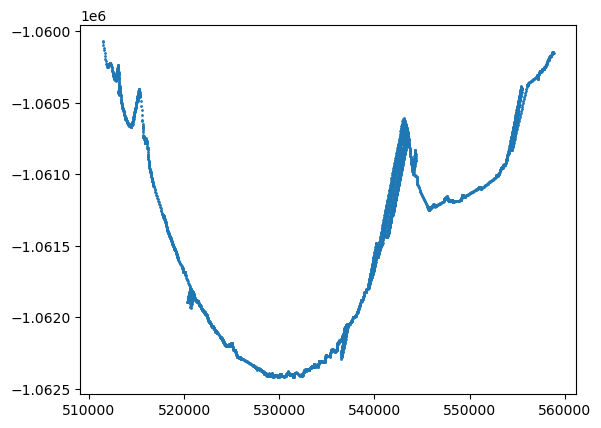

In [5]:
# check the orentation by uncommenting the line below
plt.scatter(x,y, s=1)

# if it isnt right, input an angle into the function above and rotate manually
# if it looks good, run the cell below

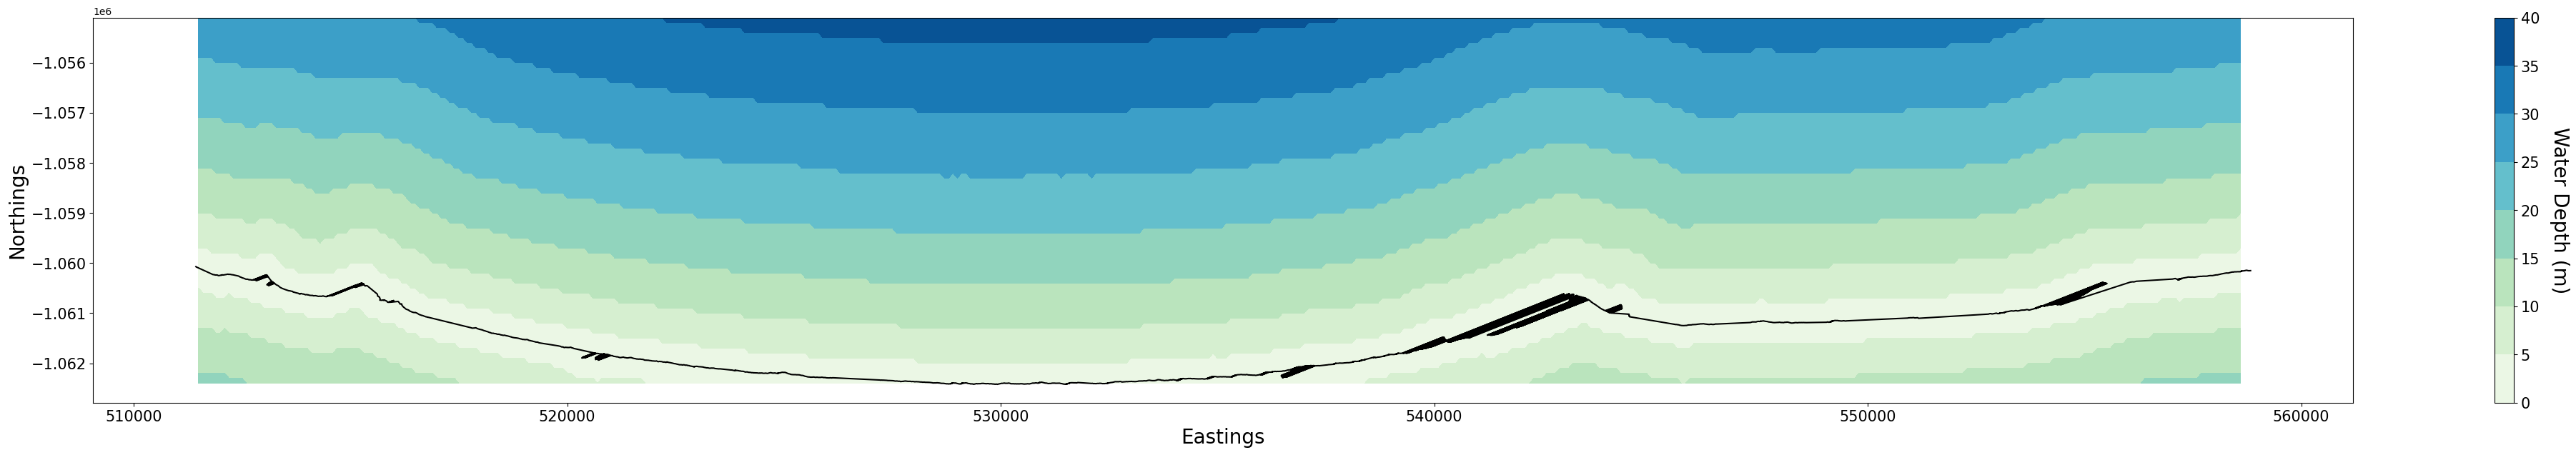

In [6]:
[xg,yg,elev] = utils.shorelinetogrid(x,y,dx,dy,plotdata=True)

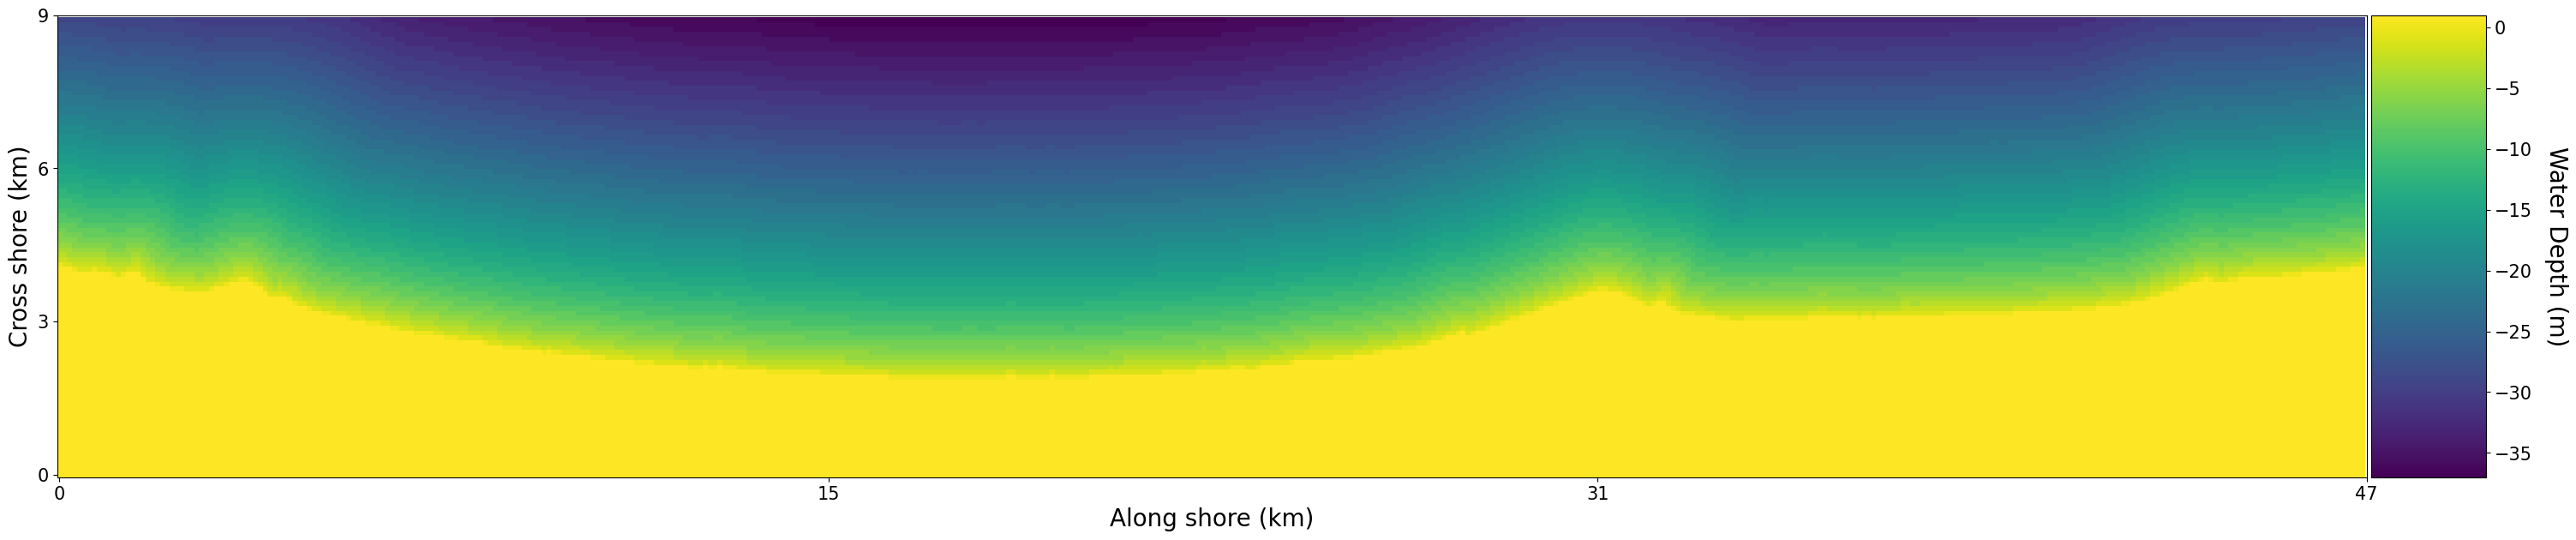

In [7]:
# we need pad to be the masked values
domain = utils.set_domain(elev, pad=20)
# visualize updated coastline data
utils.plot_coast(domain,dx,dy)

In [8]:
shelf_slope = utils.find_shelf_slope(domain, dx) ##This should be on the order of 0.001. If not you may need to find this manually
# estimation of shoreface parameters:
shoreface_slope = 4*shelf_slope ## the shoreface is steeper than the shelf
shoreface_depth = 10 # depth meters

In [9]:
from pymt.models import Cem, Waves
cem = Cem()
waves = Waves()

#convert wave direction to asymmetry term
params = {
    
    ## CEM 
    'grid_spacing'    : dx,                #meters
    'shelf_slope'     : shelf_slope,
    'shoreface_depth' : shoreface_depth,   #meters
    'shoreface_slope' : shoreface_slope,
    'model__time_step': 1,               #days
    
    ##WAVES
    'wave_height' : Hs, #meters
    'wave_period' : Tp, #seconds
    'wave_angle_highness': U, #important param
    'wave_angle_asymmetry': A
    
}

Setting end time to 3650
CEM: trying to open file: cem.txt
CEM: line: 94, 472, 100, 1

CEM: number of rows, columns: 94, 472
*** Grid size is (0,0)
*** Requested size is (94,944)
*** New grid size is (94,944)


Condition Initial 


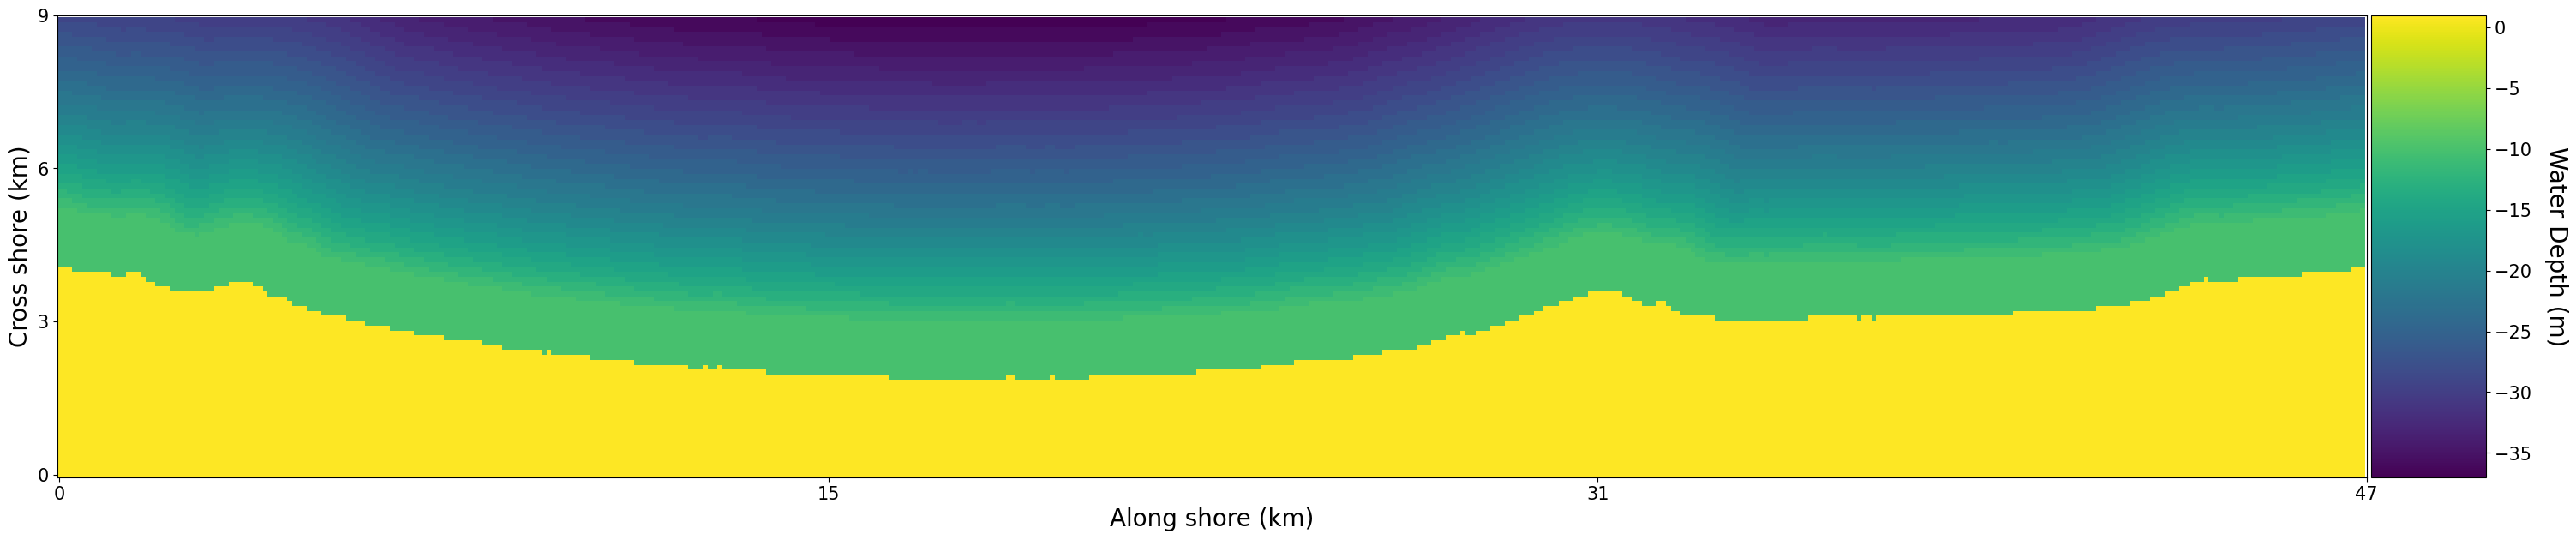

In [10]:
utils.initialize_models(params,domain,cem,waves,set_land=True)
land = cem.get_value('land_surface__elevation')
land = land.reshape(  domain.shape  )
#plot_coast(domain,dx,dy)
utils.plot_coast(land,dx,dy)

/var/folders/kr/t52nlmpn6n38qycgmd0q087c0000gn/T/ipykernel_71750/959206443.py:5: DeprecationWarning: Call to deprecated method get_var_units. (use var_units)
  cem.get_var_units("land_surface_water_sediment~bedload__mass_flow_rate")


'kg / s'

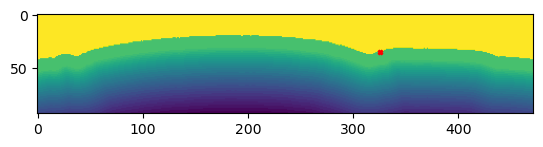

In [11]:
qs = np.zeros_like(land)
qs[35, 325] = 100
plt.imshow(land)
plt.scatter(325, 35, c='r', s=10, marker='X')
cem.get_var_units("land_surface_water_sediment~bedload__mass_flow_rate")

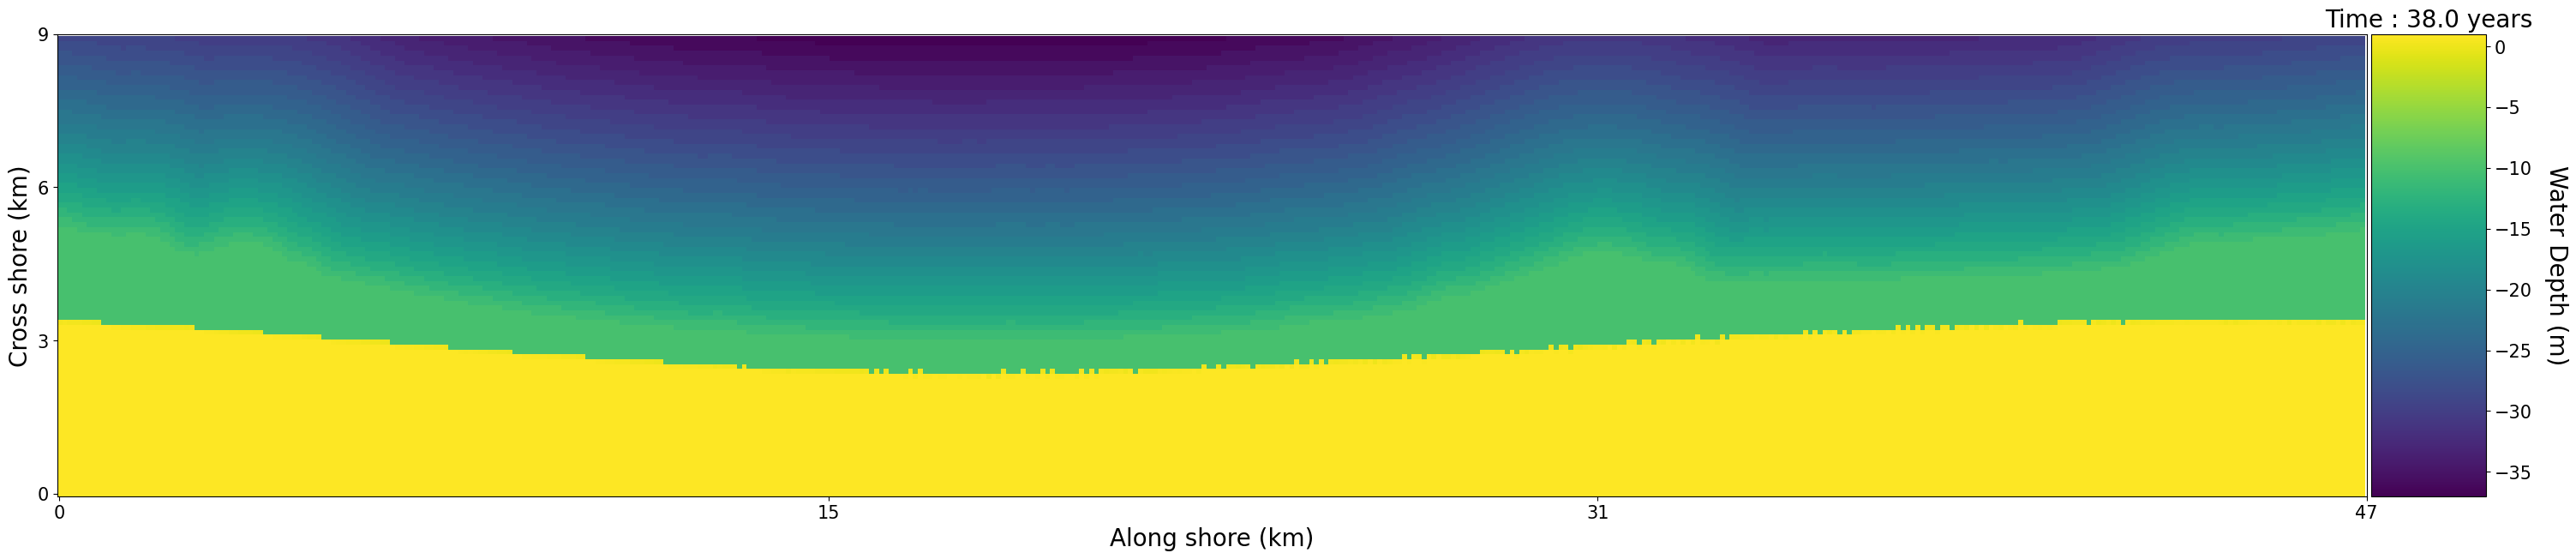

KeyboardInterrupt: 

In [12]:
time_years=500
T = int(365*time_years/cem.get_value('model__time_step'))
qs_vec = np.linspace(4,7,T)
n,m = domain.shape
qs_3 = np.zeros((n,m,T))
qs_3[35,325,:] = qs_vec
utils.run_model_loop(time_years, domain ,cem ,waves, qs_3,animate=True,update_ani_years=1)